In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

class _dataset(Dataset): #
    def __init__(self, variant, category, random_seed=42, tensor=True):
        """ 
        variant -> 'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'
        category -> 'train, validation', 'test', 'all'
        tensor -> if true will return the data as a tensor, if False will return as a DataFrame
        """
        # TODO: Improve efficiency/handle names
        
        # Sanity checks
        assert variant in {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}, "Invalid variant!"
        assert category in {'train', 'validation', 'test', 'all'}, "Invalid category!"

        # With specified variant, get data
        file = join(processed_data_path, variant + ".csv")
        data = pd.read_csv(file, index_col=0)

        # Shuffle the dataframe
        data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # This will equally devide the dataset into 
        # train, validation and test
        train, validation, test = np.split(data.sample(frac=1), [int(len(data)*(1/3)), int(len(data)*(2/3))])
        
        if category == "train":
            data = train
        elif category == "validation":
            data = validation
        elif category == "test":
            data = test
        elif category == "all":
            del train, validation, test
            self.data = data
        
        # This data we want on a seperate variable
        if category != "all":
            # Weights
            if tensor:
                self.weights = torch.from_numpy(data["weights"].to_numpy(dtype=np.float32))
            else:
                self.weights = data["weights"]
            # Name
            self.name = data["name"]

            data.drop(["name", "weights"], axis=1, inplace=True)
            # Data
            if tensor:
                self.data = torch.from_numpy(data.to_numpy(dtype=np.float32))
            else:
                self.data = data
            self.n_samples = data.shape[0]


    def __getitem__(self, index):
        return self.data[index], self.weights[index]

    def __len__(self):
        return self.n_samples

    def all_data(self):
        return self.data

## Defining the model

In [2]:
class VAE(pl.LightningModule):
    def __init__(self, trial, batch_size, dataset):
        """
        Args:
        - > variant e {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}; it's the type of data
        - > hidden_size : Latent Hidden Size
        - > alpha : Hyperparameter to control the importance of
        reconstruction loss vs KL-Divergence Loss
        - > lr : Learning Rate, will not be used if auto_lr_find is used.
        - > dataset : Dataset to used
        """
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.hparams.batch_size = batch_size
        self.hidden_size = trial.suggest_int("hidden_size", 2, 30)
        hidden_size = self.hidden_size # yes I am lazy
        self.lr = trial.suggest_float("lr", 1e-6, 1e-1, log=True)
        self.alpha = trial.suggest_int("alpha", 1, 10000)
        self.best_score = None
        ## Architecture
        # Encoder
        n_layers_encoder = trial.suggest_int("n_layers_encoder", 1, 10)
        layers = []

        in_features = 69
        for i in range(n_layers_encoder):
            out_features = trial.suggest_int("n_units_encoder_l{}".format(i), 5, 512)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.LeakyReLU())

            in_features = out_features

        # Ultima layer
        layers.append(nn.Linear(in_features, hidden_size))
        layers.append(nn.LeakyReLU())

        self.encoder = nn.Sequential(*layers)

        self.hidden2mu = nn.Linear(hidden_size, hidden_size)
        self.hidden2log_var = nn.Linear(hidden_size, hidden_size)
        
        # Decoder
        n_layers_encoder = trial.suggest_int("n_layers_decoder", 1, 10)
        layers = []

        in_features = hidden_size
        for i in range(n_layers_encoder):
            out_features = trial.suggest_int("n_units_decoder_l{}".format(i), 5, 512)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.LeakyReLU())

            in_features = out_features

        # Ultima layer
        layers.append(nn.Linear(in_features, 69))
        layers.append(nn.LeakyReLU())

        self.decoder = nn.Sequential(*layers)

        ## Load bkg data for
        # being used at self.on_epoch_end
        #self.bkg = _dataset(category='test', variant='bkg', tensor=False).all_data().to_numpy()

    def encode(self, x):
        # Pass through encoder
        out = self.encoder(x)
        mu = self.hidden2mu(out)
        log_var = self.hidden2log_var(out)
        return mu, log_var

    def decode(self, x):
        # Pass through encoder
        return self.decoder(x)

    def reparametrize(self, mu, log_var):
        # Reparametrization Trick
        # It outputs a sample of the dist.
        # mu -> average | log_var -> std
        
        log_var = torch.exp(0.5*log_var)
        z = torch.randn(size=(mu.size(0), mu.size(1))) # log_var, normal distribution
        z = z.type_as(mu)
        return mu + log_var*z

    def forward(self, x):
        # Pass through encoder
        mu, log_var = self.encode(x)
        # Reparametrization Trick
        hidden = self.reparametrize(mu, log_var)
        # Pass through decoder
        output = self.decoder(hidden)

        return mu, log_var, output, hidden

    def training_step(self, batch, batch_idx):
        x, weights = batch
        # Pass
        mu, log_var, x_out, _ = self.forward(x)

        # Losses
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)

        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)

        loss = recon_loss*self.alpha + kl_loss

        # Weights on final loss
        loss = (weights * loss) / weights.sum()
        loss = torch.mean(loss, dtype=torch.float32)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch):
        ### WIP
        x = batch
        mu, log_var, x_out, hidden = self.forward(x)

        # Loss
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss*self.alpha + kl_loss

        return  mu, log_var, x_out, hidden

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            bkg, _ = batch
            bkg = bkg.cpu().numpy()
            # Random sampling
            sample = self.decode(torch.rand(self.batch_size, self.hidden_size).to("cuda")).cpu().numpy()

            wassernstein_score = 0

            for x in range(bkg.shape[0]):
                wassernstein_score += wasserstein_distance(sample[x, :], bkg[x, :])  

            wassernstein_score = wassernstein_score / bkg.shape[0]

            self.log('wassernstein_score', wassernstein_score, prog_bar=True)

            if self.best_score is None:
                self.best_score = wassernstein_score
            elif wassernstein_score < self.best_score:
                self.best_score = wassernstein_score
            else:
                pass


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    # Functions for dataloading
    def train_dataloader(self):
        train_set = _dataset(self.dataset, category="train")
        return DataLoader(train_set, batch_size=self.batch_size, num_workers=12)

    def val_dataloader(self):
        val_set = _dataset(category='test', variant='bkg')
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)

In [3]:
def objective(trial):

    logger = TensorBoardLogger("lightning_logs", name="trial_{}".format(trial.number))

    max_epochs=trial.suggest_int("max_epochs", 50, 500, step=5)

    trainer = pl.Trainer(
        gpus=1,
        logger=logger,
        max_epochs=max_epochs,
        precision=16,
        check_val_every_n_epoch=5,
        callbacks=[
            PyTorchLightningPruningCallback(trial, monitor="wassernstein_score"),
            ModelCheckpoint(dirpath="models", filename="trial_{}".format(trial.number), monitor="wassernstein_score", mode="min")]
    )

    model = VAE(trial, dataset = "bkg", batch_size=4048)
    trainer.fit(model)

    return model.best_score

## Training

In [8]:
study = optuna.create_study(direction="minimize", study_name="Optimizing the VAE")
study.optimize(objective, timeout=10*60*60)#n_trials=200)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)


import joblib
joblib.dump(study, "study.pkl")

0it [00:00, ?it/s]
Epoch 29:  50%|█████     | 92/184 [00:02<00:02, 38.70it/s, loss=nan, v_num=0, wassernstein_score=0.531, train_loss=nan.0]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 91/92 [00:13<00:00,  7.02it/s][W 2021-06-27 15:36:32,303] Trial 0 failed because of the following error: IntegrityError('(sqlite3.IntegrityError) NOT NULL constraint failed: trial_intermediate_values.intermediate_value')
Traceback (most recent call last):
  File "/home/acujl/.local/lib/python3.8/site-packages/sqlalchemy/engine/base.py", line 1770, in _execute_context
    self.dialect.do_execute(
  File "/home/acujl/.local/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 717, in do_execute
    cursor.execute(statement, parameters)
sqlite3.IntegrityError: NOT NULL constraint failed: trial_intermediate_values.intermediate_value

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/acujl/.local/lib/python3.8/site

IntegrityError: (sqlite3.IntegrityError) NOT NULL constraint failed: trial_intermediate_values.intermediate_value
[SQL: INSERT INTO trial_intermediate_values (trial_id, step, intermediate_value) VALUES (?, ?, ?)]
[parameters: (1, 29, nan)]
(Background on this error at: http://sqlalche.me/e/14/gkpj)

### Optuna Graphs

In [4]:
import joblib
study = joblib.load("study.pkl")

In [5]:
optuna.visualization.plot_param_importances(study)

In [6]:
optuna.visualization.plot_intermediate_values(study)

In [7]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [6]:
import joblib
study = joblib.load("study.pkl")

model = VAE.load_from_checkpoint(
    join('models', f"trial_{study.best_trial.number}.ckpt"),
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=4048)

model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=43, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=43, out_features=11, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (hidden2mu): Linear(in_features=11, out_features=11, bias=True)
  (hidden2log_var): Linear(in_features=11, out_features=11, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=11, out_features=383, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=383, out_features=165, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=165, out_features=69, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

### Load data

In [4]:
# Sinal
data = pd.concat([
     _dataset(category='all',variant='VLQ_HG').all_data()
    ,_dataset(category='all',variant='VLQ_SEM_HG').all_data()
    ,_dataset(category='all',variant='FCNC').all_data()
    ])

# Bkg
bkg = _dataset(category='test',variant='bkg', tensor=False).all_data()
bkg['name'] = 'background.csv'
data = pd.concat([data, bkg])

data.drop(columns=['weights'], inplace=True)
data.describe()


/home/acujl/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean       -0.001663      -0.000141      -0.000274      -0.001484   
std         0.998918       1.001239       1.000099       0.996326   
min        -5.319242      -4.101005      -2.998802      -1.426919   
25%        -0.506770      -0.581605      -0.856784      -0.459476   
50%        -0.114884      -0.043217      -0.130696      -0.220869   
75%         0.791427       0.537871       0.705107      -0.171740   
max         9.401355      12.975352      10.765291      17.167487   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean       -0.002289      -0.002594      -0.000291       0.000234   
std         0.977284       0.863567       1.000119       1.000034   
min        -0.605231      -0.189027      -3.535722      -2.437525   
25%        -0.129339      -0.031524      -0.785960      -0.742107   
50%        -0.096728      -0.024664      -0.068877      -0.331509   
75%        -0.047287      -0.010815       0.635032       0.582328   
max        43.479936      94.948034      19.916800      12.739534   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  527817.000000  527817.000000  ...   527817.000000  527817.000000   
mean       -0.001315      -0.001545  ...       -0.000475       0.000912   
std         0.995192       0.988279  ...        0.999821       1.000282   
min        -1.199560      -0.539097  ...       -1.336158      -1.218623   
25%        -0.388786      -0.113399  ...       -0.810386      -0.710694   
50%        -0.193727      -0.086368  ...       -0.781252      -0.572371   
75%        -0.151859      -0.041419  ...        1.198572       0.537680   
max        21.573988      57.254496  ...        4.526157      11.705100   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  527817.000000  527817.000000  527817.000000  527817.000000   
mean        0.000153       0.000339       0.000663       0.001537   
std         1.000497       0.999401       0.999154       0.998867   
min        -0.673532      -4.319071      -5.501854      -2.832453   
25%        -0.534342      -0.005541      -0.004436      -0.004365   
50%        -0.487050       0.000813      -0.000362      -0.000101   
75%         0.182599       0.007525       0.001253       0.008770   
max        14.925601       4.244353       5.475033       2.827034   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  527817.000000  527817.000000  527817.000000  527817.000000  
mean       -0.002484      -0.001245      -0.000146      -0.000201  
std         0.999482       0.999169       1.000597       0.999018  
min        -4.061617      -1.529808      -1.755112      -2.533251  
25%        -0.000624      -0.663273      -0.867415      -0.705297  
50%         0.001715      -0.274170       0.000160      -0.240930  
75%         0.005244       0.367087       0.867741       0.449881  
max         4.044430      19.050344       1.774142      14.938015  

[8 rows x 69 columns]

## Check if z ~ N(0,1)

In [11]:
mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.drop(columns=['name']).to_numpy(dtype=np.float32)))
hidden = hidden.detach().numpy()
hidden.shape

(527817, 11)

In [12]:
z0 = hidden[:, 0]
z1 = hidden[:, 1]
z0.shape, z1.shape

((527817,), (527817,))

Mean: -0.14282037 Std: 0.8542198


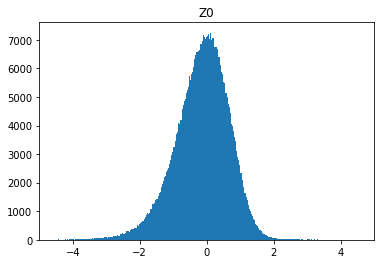

In [15]:
_ = plt.hist(z0, bins='auto')
plt.xlim(-5, 5)
plt.title("Z0")
print("Mean:", z0.mean(), "Std:", z0.std())


Mean: 0.011988213 Std: 1.0376121


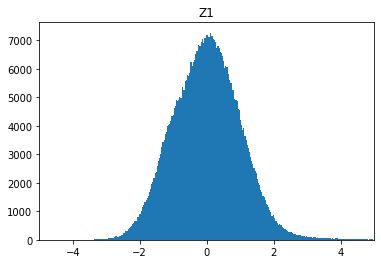

In [16]:
_ = plt.hist(z1, bins='auto')
plt.xlim(-5, 5)
plt.title("Z1")
print("Mean:", z1.mean(), "Std:", z1.std())


In [ ]:
wass

## Random sampling and comparing distributions with bkg data

In [17]:
bkg.drop(columns=['name'], inplace=True)

In [21]:

# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], 11)).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

FatJet_Multi     FatJet1_PT     FatJet2_PT     FatJet3_PT  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean        0.483053       0.127818       0.650274      -0.272461   
std         0.327489       0.214212       0.513931       0.035866   
min        -0.608256      -0.943864      -0.835564      -0.441054   
25%         0.293582      -0.002233       0.351427      -0.295948   
50%         0.533270       0.012468       0.715497      -0.272749   
75%         0.717313       0.235819       1.008333      -0.249067   
max         1.892902       1.532615       2.880476      -0.087874   

          FatJet4_PT     FatJet5_PT   FatJet1_Mass   FatJet2_Mass  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean       -0.086849      -0.043248      -0.170087       0.386365   
std         0.011832       0.008107       0.438177       0.615548   
min        -0.130530      -0.089126      -1.483757      -0.732640   
25%        -0.094996      -0.048502      -0.520495      -0.008699   
50%        -0.087181      -0.042976      -0.158896       0.029416   
75%        -0.079036      -0.037715       0.191838       0.747690   
max        -0.034812      -0.014585       1.203338       3.734226   

        FatJet3_Mass   FatJet4_Mass  ...  Electron_Multi   Electron1_PT  \
count  370198.000000  370198.000000  ...   370198.000000  370198.000000   
mean       -0.250164      -0.055730  ...        0.865965       2.138421   
std         0.029633       0.012517  ...        0.374523       0.619806   
min        -0.391770      -0.108277  ...       -0.436500      -0.346390   
25%        -0.269843      -0.064351  ...        0.555806       1.760560   
50%        -0.251007      -0.055466  ...        0.855969       2.156935   
75%        -0.230649      -0.046818  ...        1.195553       2.545026   
max        -0.091895      -0.009508  ...        2.176245       4.685424   

        Electron2_PT  Electron1_Eta  Electron2_Eta  Electron1_Phi  \
count  370198.000000  370198.000000  370198.000000  370198.000000   
mean        0.057604       0.593655       0.248964       0.463867   
std         0.423727       0.546184       0.421352       1.072901   
min        -0.502046      -0.993353      -1.019521      -1.495013   
25%        -0.174657       0.111850      -0.006829      -0.256777   
50%        -0.065700       0.541053      -0.000760      -0.005288   
75%        -0.000778       0.971839       0.456476       1.260942   
max         4.301969       3.630548       2.628191       5.417507   

       Electron2_Phi  MissingET_MET  MissingET_Phi    ScalarHT_HT  
count  370198.000000  370198.000000  370198.000000  370198.000000  
mean       -0.228297      -0.094426       0.318528      -0.330628  
std         0.334114       0.517819       0.319365       0.275832  
min        -1.806040      -1.065045      -0.382389      -1.234587  
25%        -0.345927      -0.359037      -0.000162      -0.539774  
50%        -0.035327      -0.211993       0.253361      -0.336076  
75%        -0.025329      -0.032799       0.544900      -0.121160  
max        -0.002895       4.513043       1.629962       1.521913  

[8 rows x 69 columns]

In [22]:
def plot_graphs2(background, signal, bins=50, num_cols=4):

    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(signal.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label='Real', range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label='Sampled',  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

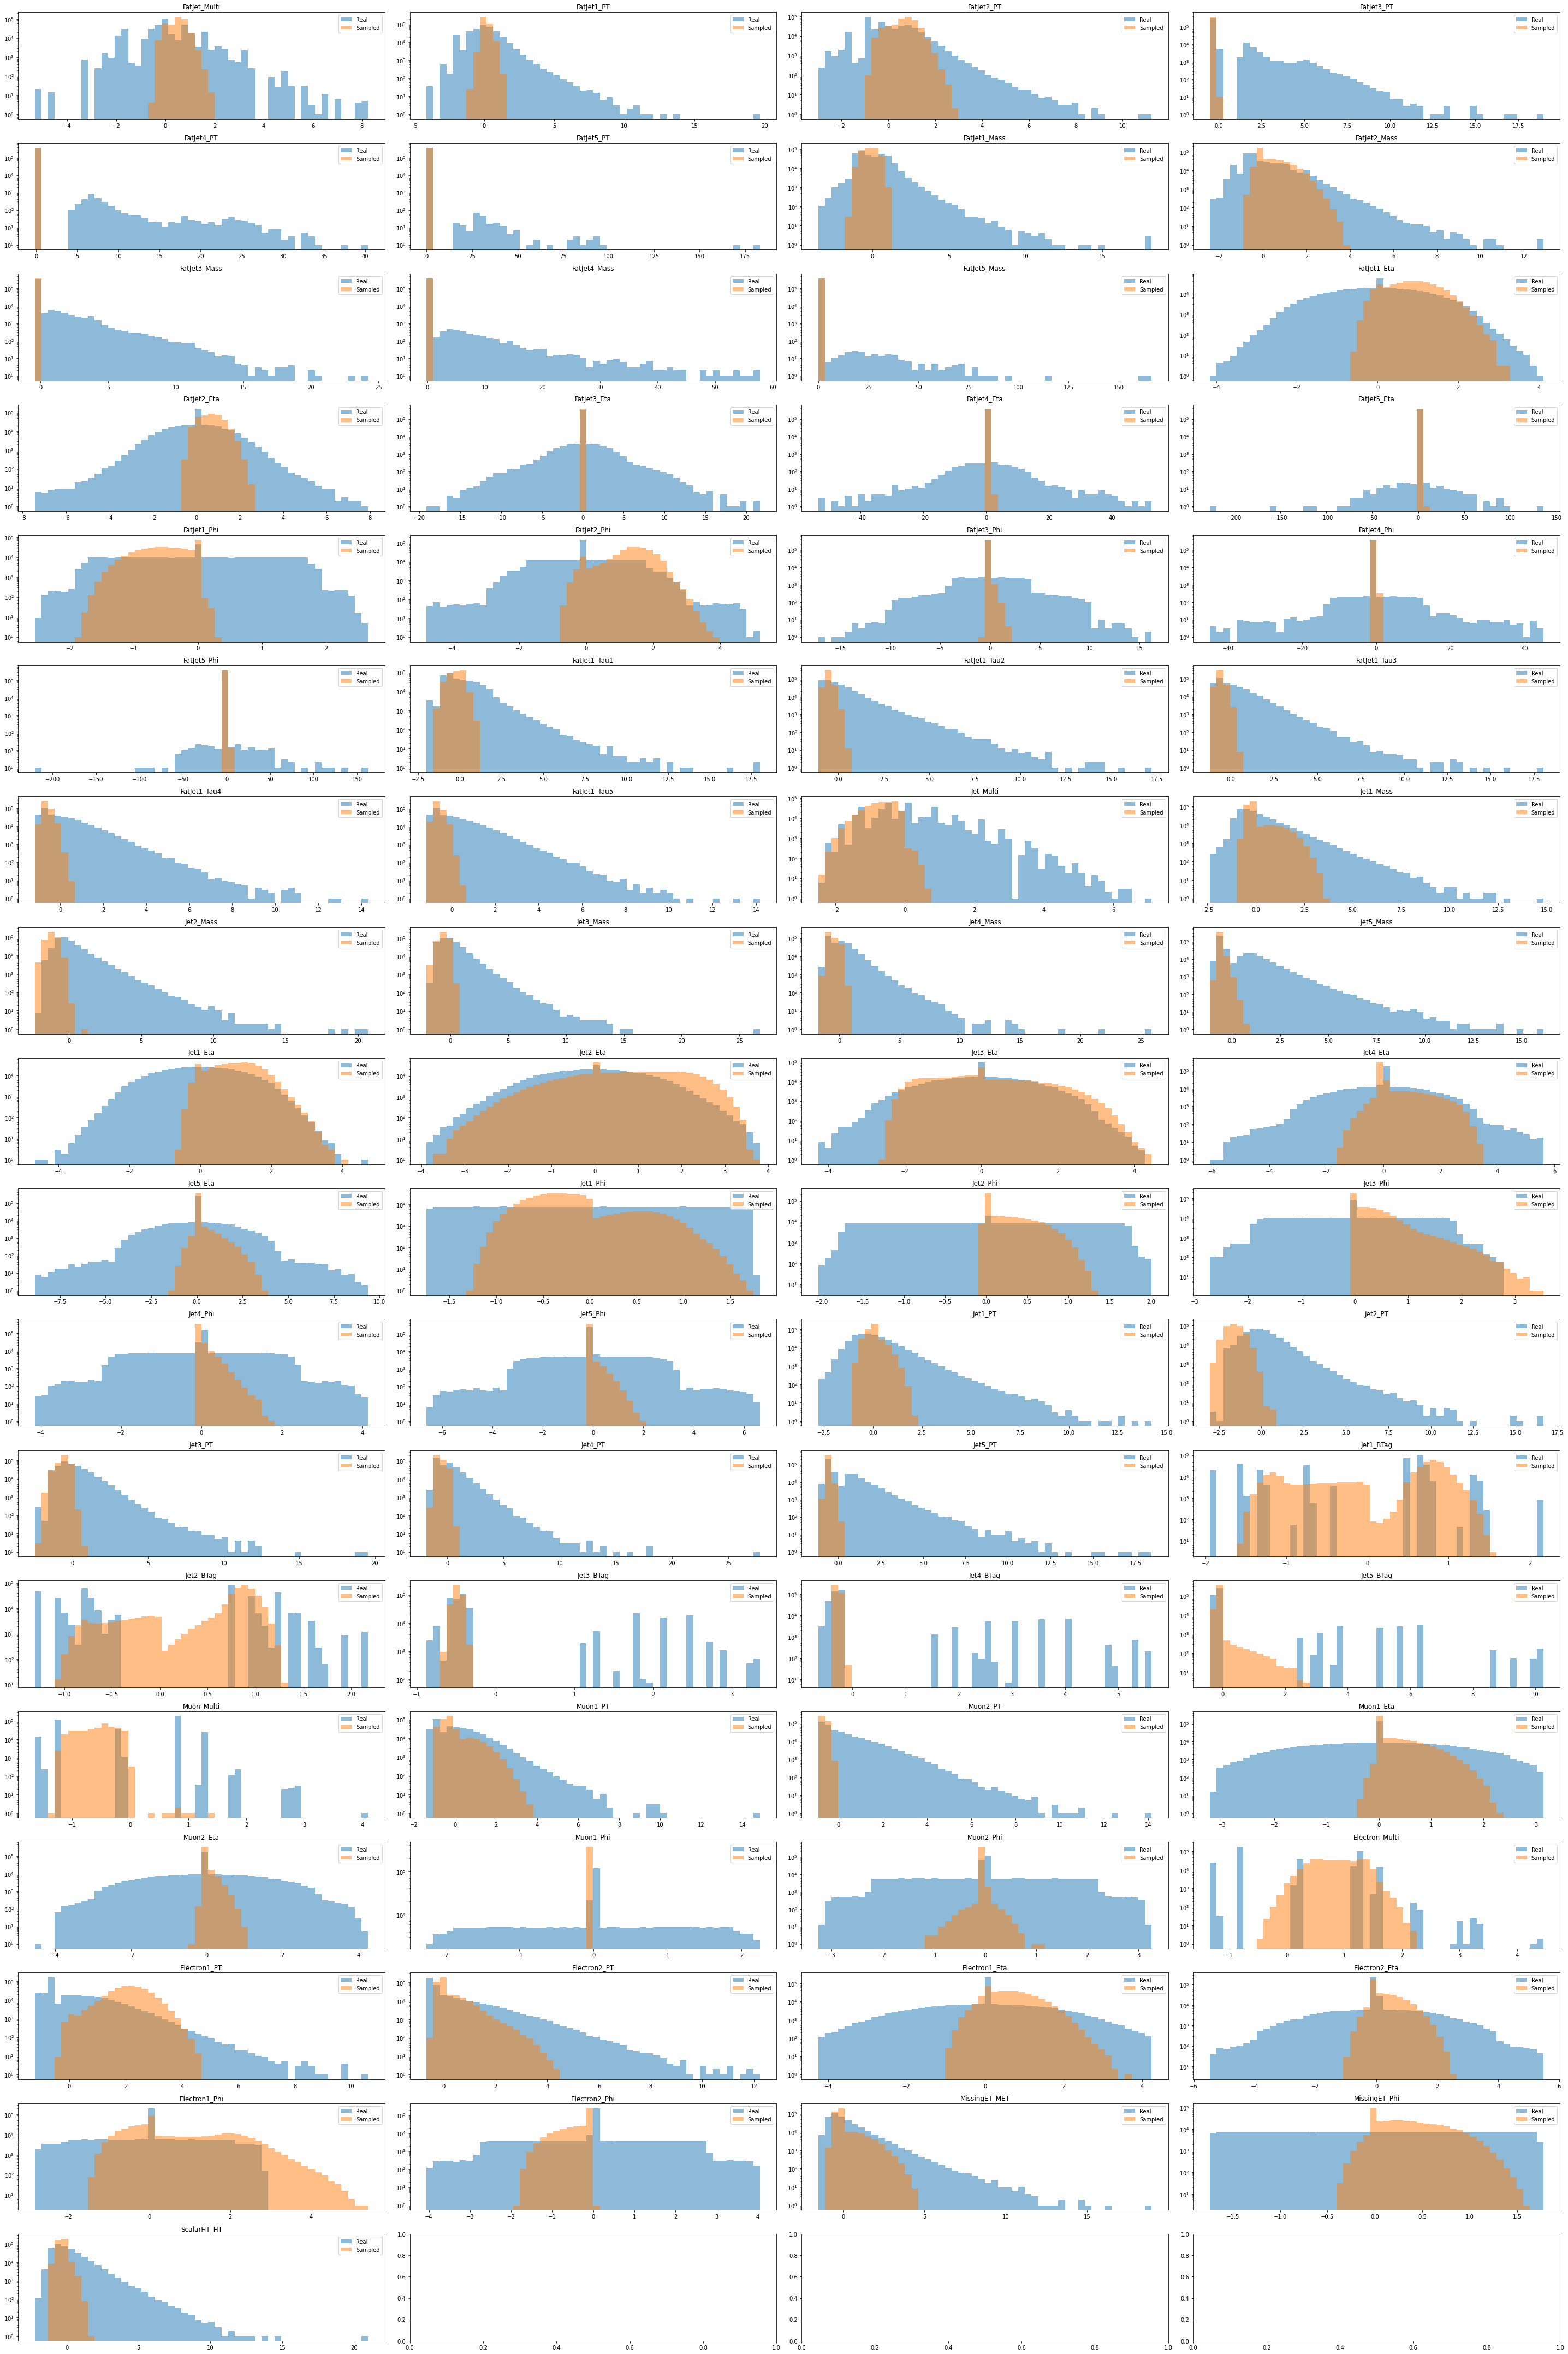

In [23]:
plot_graphs2(bkg, sample)

Plot latent space

  0%|          | 0/6 [00:00<?, ?it/s]

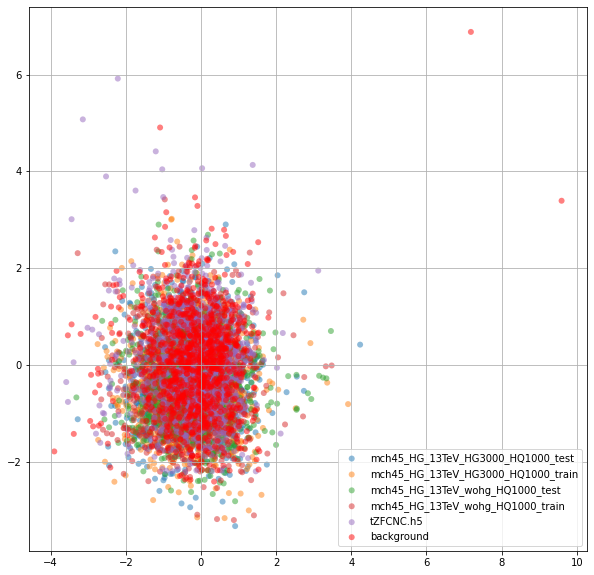

In [7]:
fig, ax = plt.subplots( figsize=(10,10))
for x in tqdm(data['name'].unique()):
    mu, log_var, x_out, hidden = model.test_step(torch.from_numpy(data.loc[data['name'] == x].drop(columns=['name']).to_numpy(dtype=np.float32)))
    hidden = hidden.detach().numpy()

    if x != 'background.csv':
        color = None
    else:
        color = 'r'

    ax.scatter(hidden[:1000, 0], hidden[:1000, 1], label=x.replace('.csv', ''), alpha=0.5, edgecolors='none', c = color)

ax.legend()
ax.grid(True)

plt.show()
